In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

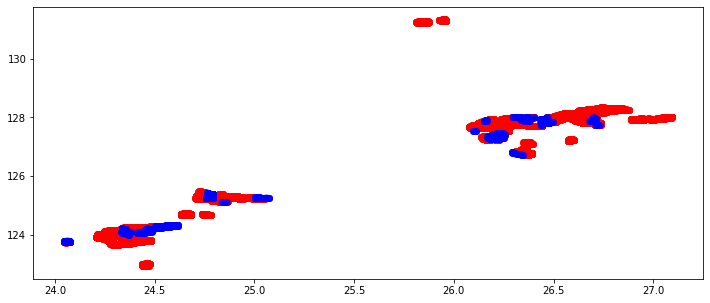

In [6]:
fig = plt.figure(figsize = (12,5))
plt.scatter(train.lat,train.lon, c="r", alpha=.8)
plt.scatter(test.lat,test.lon, c="b", alpha=.3)

 
plt.show()

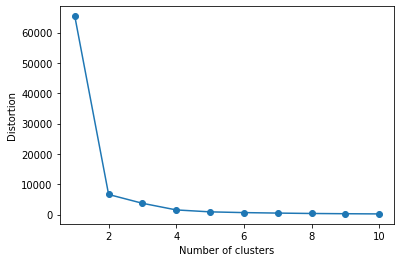

In [7]:
from sklearn.cluster import KMeans

distortions = []

for i  in range(1,11):                # 1~10クラスタまで一気に計算 
    km = KMeans(n_clusters=i,
                init='k-means++',     # k-means++法によりクラスタ中心を選択
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(train[["lat","lon"]])                         # クラスタリングの計算を実行
    distortions.append(km.inertia_)   # km.fitするとkm.inertia_が得られる

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [8]:
km = KMeans(n_clusters=10,
                init='k-means++',     # k-means++法によりクラスタ中心を選択
                n_init=10,
                max_iter=300,
                random_state=0)

k_clust = km.fit_predict(train[["lat","lon"]])
test_k_clust = km.predict(test[["lat","lon"]])
train["clust"] = k_clust
test["clust"] = test_k_clust

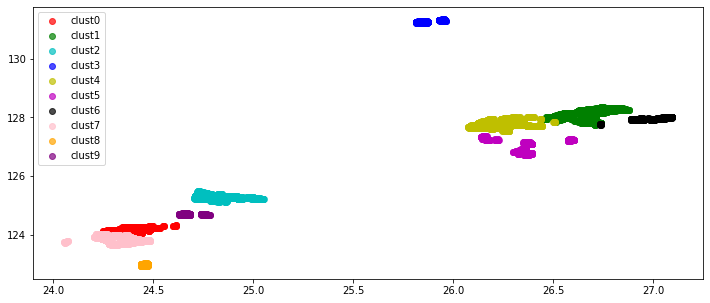

In [9]:
fig = plt.figure(figsize = (12,5))
colors = ["r","g","c","b","y","m","k","pink","orange","purple"]
for i in range(10):
  plt.scatter(train.loc[train["clust"]==i]["lat"],train.loc[train["clust"]==i]["lon"], c=colors[i], alpha=.7, label=f"clust{i}")

plt.legend() 
plt.show()

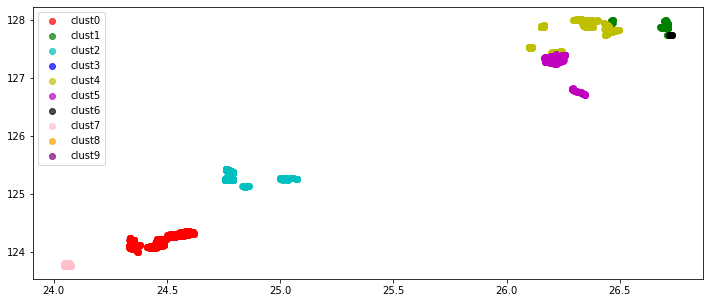

In [10]:
fig = plt.figure(figsize = (12,5))
colors = ["r","g","c","b","y","m","k","pink","orange","purple"]
for i in range(10):
  plt.scatter(test.loc[test["clust"]==i]["lat"],test.loc[test["clust"]==i]["lon"], c=colors[i], alpha=.7, label=f"clust{i}")

plt.legend() 
plt.show()

In [11]:
train["clust_month"] = train["clust"].astype(str) + "_" + train["month"].astype(str)
test["clust_month"] = test["clust"].astype(str) + "_" + test["month"].astype(str)

In [12]:
clust_df = train.groupby("clust_month")["cover"].agg("mean").reset_index()
clust_df.rename(columns={"cover":"clust_mean"},inplace=True)

train = train.merge(clust_df, how="left", on="clust_month")
test = test.merge(clust_df, how="left", on="clust_month")

In [13]:
train

,id,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,clust,clust_month,clust_mean
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.000000,...,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10,2,2_9.0,0.052384
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.000000,...,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13,6,6_7.0,0.539862
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.000000,...,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22,4,4_10.0,0.036297
3,3,26.991255,127.912302,40.0,2009.1.13-2009.2.19,2009.0,1.0,0.575,NaN,0.000000,...,-0.860716,-2.373051,2.988302,51.879647,6.054869,-5.697032,4027_13,6,6_1.0,0.522189
4,4,26.988254,127.917254,40.0,2009.1.13-2009.2.19,2009.0,1.0,0.225,NaN,0.000000,...,-0.882317,-2.095053,2.436510,50.467718,8.537779,-1.617806,4027_13,6,6_1.0,0.522189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14135,14135,24.728611,125.403889,20.0,20110925,2011.0,9.0,0.050,NaN,1294.458862,...,-0.703634,-1.458936,2.081548,202.985223,-497.151601,-449.711425,3725_01,2,2_9.0,0.052384
14136,14136,27.002425,127.927444,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.300,NaN,0.000000,...,-0.881558,-3.932485,4.284944,66.766629,3.086038,-18.261736,4027_23,6,6_7.0,0.539862
14137,14137,24.797444,125.162417,20.0,20120204.0,2012.0,2.0,0.050,NaN,0.000000,...,-0.852988,-2.470451,2.327925,54.130453,4.699174,-15.904502,3725_00,2,2_2.0,0.063684
14138,14138,26.999893,127.922014,40.0,2009.4.3-2009.5.15,2009.0,4.0,0.425,NaN,0.000000,...,-0.658219,-4.530392,-80.506948,1016.155119,1.708610,0.329458,4027_13,6,6_4.0,0.577602


In [14]:
class CFG:
  ver=66
  model="rule_base"
  seed="None"

In [15]:
def rmse(y_true,y_pred):
    #RMSEを算出
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    print('RMSE : ',rmse)
    return rmse

In [16]:
rmse(train["cover"], train["clust_mean"])

RMSE :  0.20396724737215446


0.20396724737215446

In [17]:
cover_mean = train.cover.mean()
test["clust_mean"] = test["clust_mean"].fillna(cover_mean)

In [18]:
test[["clust_mean"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

In [19]:
test.head(10)

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,clust,clust_month,clust_mean
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20,0,0_12.0,0.119963
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20,0,0_7.0,0.052597
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23,4,4_2.0,0.320000
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,-0.863338,-2.708627,-10.433323,45.061952,1.546086,-14.527890,3927_11,5,5_8.0,0.050000
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,-0.824787,-5.249625,2.563503,80.374689,1.827876,-6.335208,3725_01,2,2_10.0,0.238238
5,5,24.353007,124.198957,20.0,2002.12,2002.0,12.0,0.1,NaN,NaN,...,-0.050996,2.126983,3.735545,3113.283130,-0.380021,0.310094,3624_20,0,0_12.0,0.119963
6,6,26.216556,127.293389,20.0,20100611,2010.0,6.0,NaN,0.000000,227.900101,...,-0.920788,-2.188553,1.360362,39.658558,3.315382,-2.633826,3927_11,5,5_6.0,0.050000
7,7,26.706529,127.910159,20.0,NaN,2019.0,9.0,9.5,0.000000,340.516205,...,-0.860792,-2.323698,2.488297,62.684629,5.225177,-4.600182,4027_03,1,1_9.0,0.077964
8,8,26.198960,127.444742,20.0,20100609,2010.0,6.0,NaN,0.000000,0.000000,...,-0.846328,-2.609254,-3.017697,62.376708,0.272568,-3.105368,3927_11,4,4_6.0,0.183183
9,9,24.562917,124.334667,20.0,20101001,2010.0,10.0,NaN,0.000000,0.000000,...,-0.857522,-2.439044,2.559698,54.377731,4.159146,-10.057813,3624_31,0,0_10.0,0.157267
